In [5]:
import os
import sys

In [6]:
from scipy.special import factorial

In [7]:
sys.path.append('../lib')

In [8]:
import gen_processes;
import ast

In [9]:
from importlib import reload
reload(gen_processes);

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_default_dtype(torch.double)

In [11]:
from tqdm import tqdm

In [12]:
from itertools import product

In [13]:
import matplotlib.pyplot as plt

In [14]:
import esig

In [15]:
esig.set_backend("iisignature")

In [16]:
from esig import tosig
from scipy.optimize import brentq

In [36]:
def get_keys(dim, order):
    s = tosig.sigkeys(dim, order)

    tuples = []

    for t in s.split():
        if len(t) > 2:
            t = t.replace(")", ",)")

        tuples.append(ast.literal_eval(t))

    return tuples

def f(z, a, keys):
    dilation = np.array([z ** (2*len(t)) for t in keys])
    out = np.dot(a, dilation)
    return out

def phi(x, order):
    keys = get_keys(2, order)
    x = np.array(x)
    a = x ** 2

    return max(min(brentq(lambda z: f(z, a, keys) - psi(norm(x)), 0, 1.001), 1), 0)

def psi(x, M=4, a=1):
    x = x ** 2

    if x <= M:
        return x

    return M + M ** (1 + a) * (M ** (-a) - x ** (-a)) / a

def norm(x):
    return np.linalg.norm(x)

def normalize_sig(sig, order, cheatnum = None):
    keys = get_keys(2, order)

    if cheatnum is None:
        phi_x = phi(tuple(sig), order)
    else:
        phi_x = cheatnum    

    Lambda = np.array([phi_x ** len(t) for t in keys])
    
    return Lambda * sig

def get_normalize_sig_const(sig, order):
    phi_x = phi(tuple(sig), order)
    return phi_x

def get_normalized_gram_matrix_for_paths(paths, order):
    n = paths.shape[0]
    gram = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            sig_i = normalize_sig(esig.stream2sig(paths[i, :, :].reshape(30, 2), order), order)
            sig_j = normalize_sig(esig.stream2sig(paths[j, :, :].reshape(30, 2), order), order)
            gram[i, j] = sig_i @ sig_j.T
    
    return gram

In [18]:
RNG = np.random.default_rng(1234)

In [19]:
processes = gen_processes.gen_ar_iid_samples_burn_in(31, 20, 0, rng = RNG).numpy()
# Indices: Sample, Time, Lead/Lag
processes_ll = np.dstack((processes[:, 1:, 0], processes[:, :30, 0]))
processes_ll = processes_ll/4

In [20]:
def get_lead_lag_proc_length(proc):
    return np.sqrt(np.diff(proc[0])**2 + np.diff(proc[1])**2).sum()

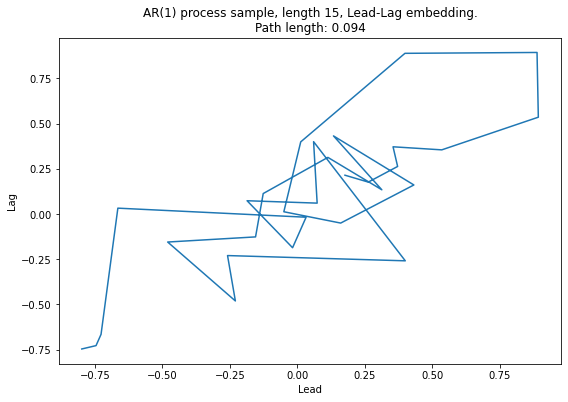

In [21]:
plt.figure(figsize=(9,6))
plt.plot(processes_ll[0, :, 0].reshape(30), processes_ll[0, :,1].reshape(30))
plt.xlabel('Lead')
plt.ylabel('Lag')
plt.title("AR(1) process sample, length 15, Lead-Lag embedding.\nPath length: {:.3f}".format(get_lead_lag_proc_length(processes_ll[0, :].reshape(30, -1))))
plt.savefig('./pics/sig_mistery_ar1_ll_embedding.png')

## Unnormalized signatures and their normalizing constants

In [22]:
get_lead_lag_proc_length(processes_ll[0, :, :])

0.09446812826814911

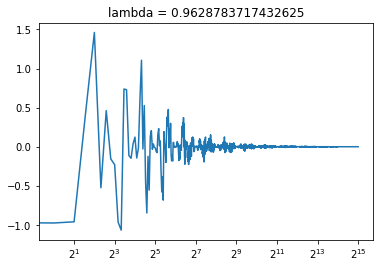

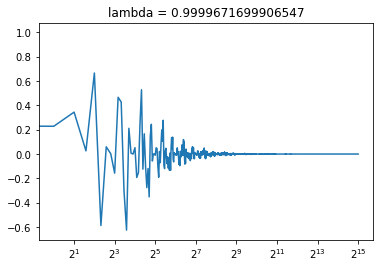

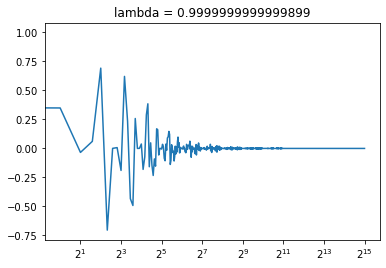

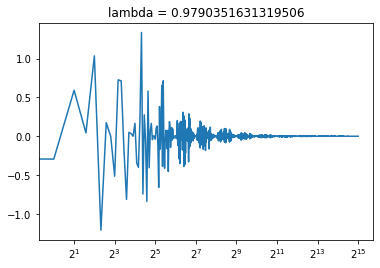

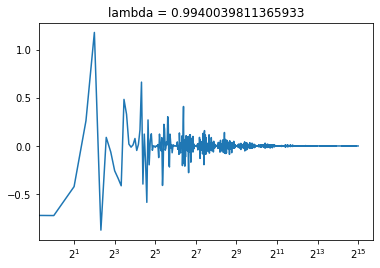

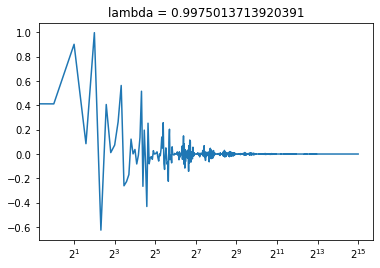

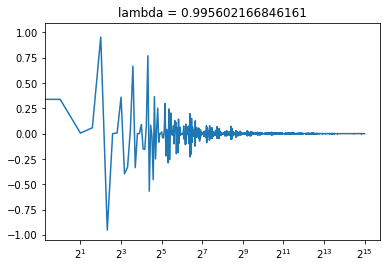

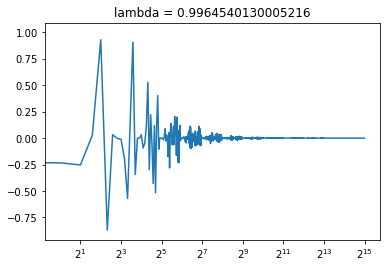

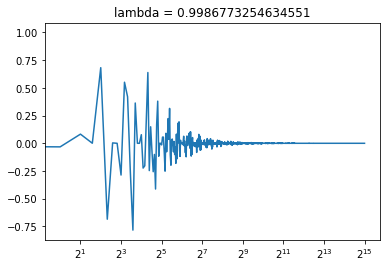

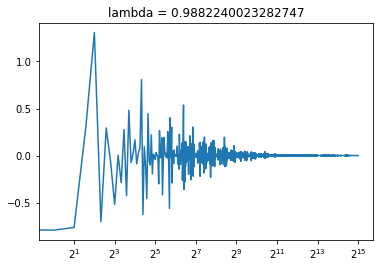

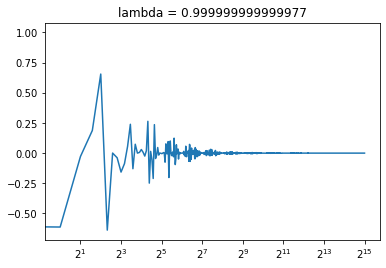

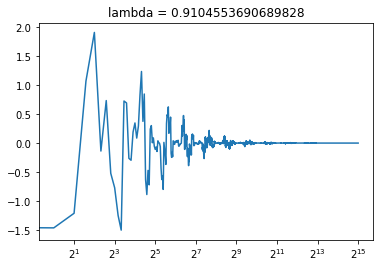

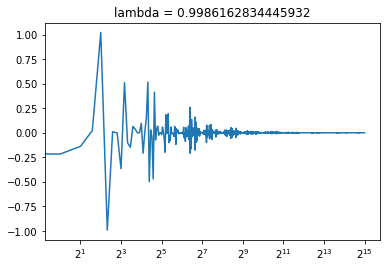

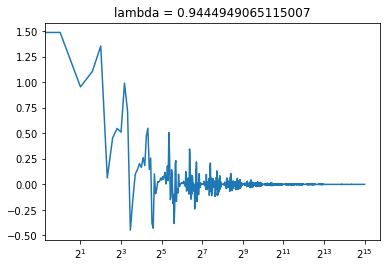

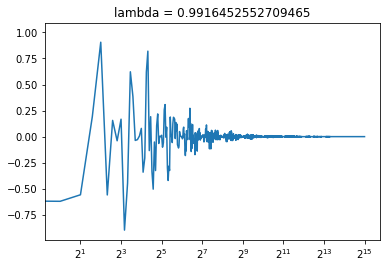

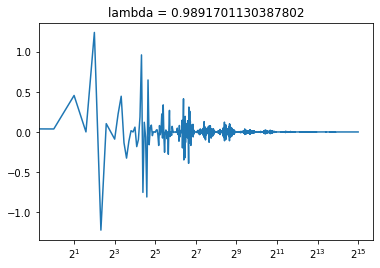

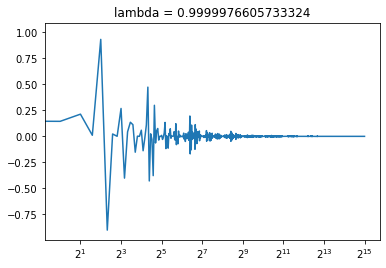

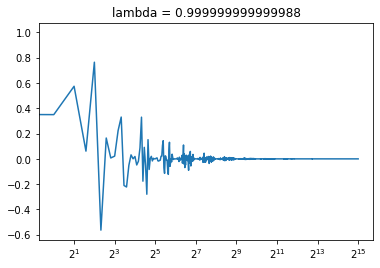

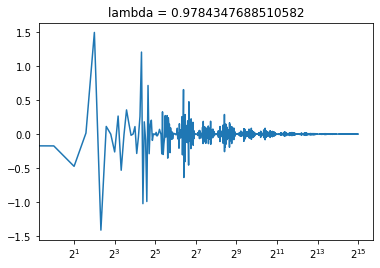

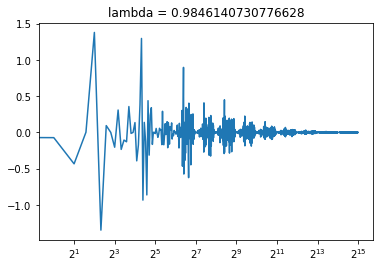

In [23]:
for sample in range(20):
    plt.figure()
    sig_s = esig.stream2sig(processes_ll[sample, :, :].reshape(30, 2), 14)
    lamb = get_normalize_sig_const(sig_s, 14)
    plt.title('lambda = {}'.format(lamb))
    plt.plot(sig_s)
    plt.xscale('log', base = 2)

## Normalized sig vs. unnormalized and scaled - CONFIRMED

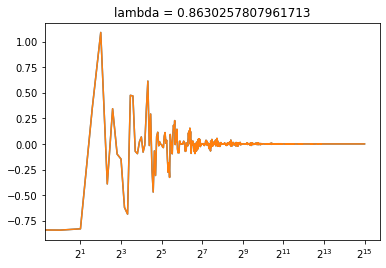

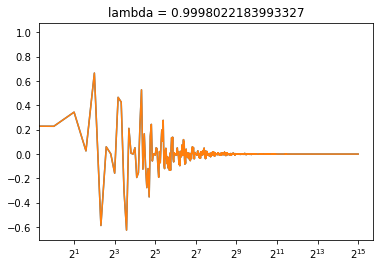

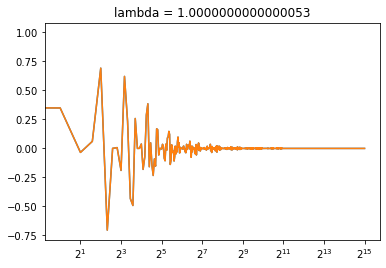

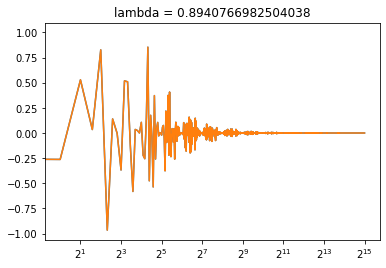

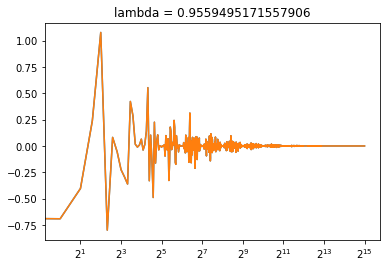

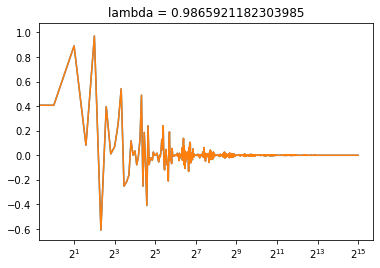

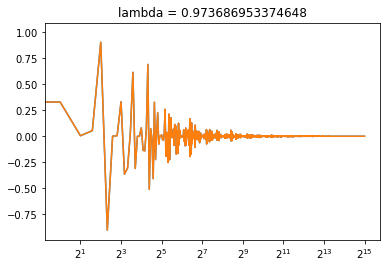

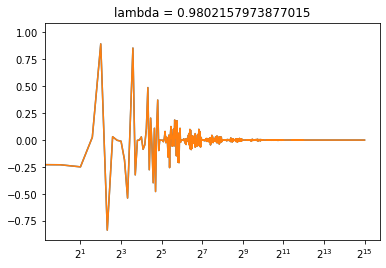

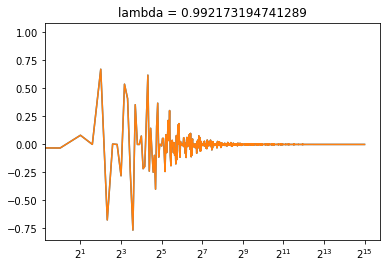

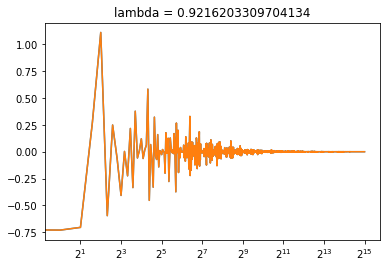

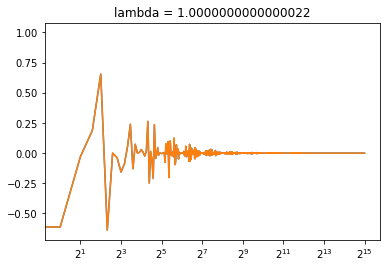

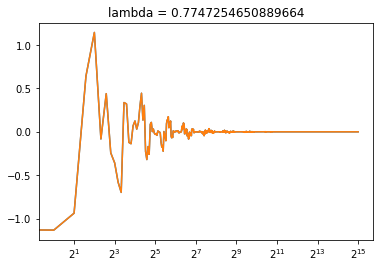

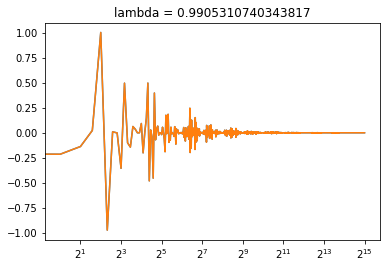

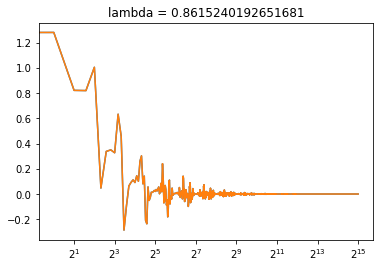

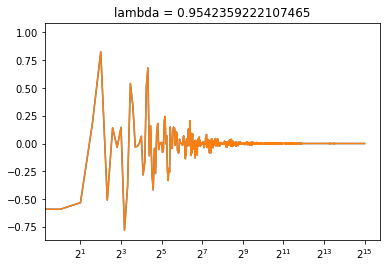

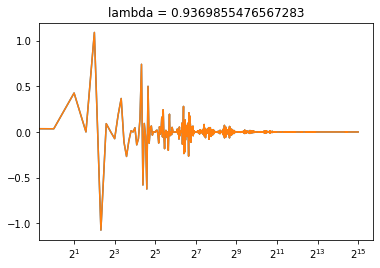

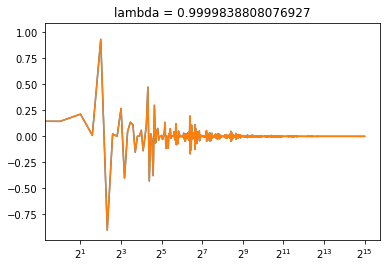

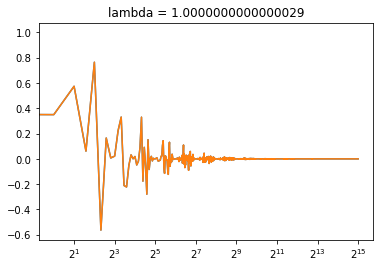

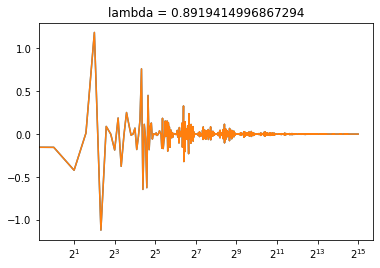

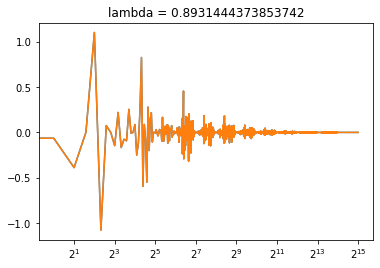

In [40]:
for sample in range(20):
    sig_s = esig.stream2sig(processes_ll[sample, :, :].reshape(30, 2), 14)
    lamb = get_normalize_sig_const(sig_s, 14)
    
    sig_norm = normalize_sig(sig_s, 14)
    sig_unnorm_scaled = esig.stream2sig(lamb*processes_ll[sample, :, :].reshape(30, 2), 14)
    
    plt.figure()
    plt.plot(sig_norm)
    plt.plot(sig_unnorm_scaled)
    plt.title('lambda = {}'.format(lamb))
    plt.xscale('log', base = 2)
    plt.show()

In [ ]:
gram_matrix = get_normalized_gram_matrix_for_paths(processes_ll, 14)

In [ ]:
lambdas = np.zeros(20)

In [ ]:
for sample in range(20):
    sig_s = esig.stream2sig(processes_ll[sample, :, :].reshape(30, 2), 14)
    lamb = get_normalize_sig_const(sig_s, 14)
    
    lambdas[sample] = lamb

In [26]:
import pickle

In [114]:
RESULTS = {
    'processes_lead_lag' : processes_ll,
    'lambdas' : lambdas,
    'gram_matrix' : gram_matrix, 
    'comment' : 'Process indices: Sample, Time, Lead/Lag'
}

In [27]:
with open('pickles/comparison_ds_for_normalized_sig_pde_kernel.pickle', 'rb') as file:
    RESULTS = pickle.load(file)

In [28]:
RESULTS

{'processes_lead_lag': array([[[ 0.17681574,  0.21490928],
         [ 0.26326288,  0.17681574],
         [ 0.37201756,  0.26326288],
         ...,
         [-0.72741271, -0.66506784],
         [-0.74598178, -0.72741271],
         [-0.79884318, -0.74598178]],
 
        [[ 0.03278709,  0.17039214],
         [-0.13589813,  0.03278709],
         [-0.15025423, -0.13589813],
         ...,
         [ 0.37871911,  0.36744782],
         [ 0.51514197,  0.37871911],
         [ 0.26129079,  0.51514197]],
 
        [[ 0.14949934,  0.28497361],
         [ 0.05479762,  0.14949934],
         [ 0.0508062 ,  0.05479762],
         ...,
         [ 0.15522894, -0.17764543],
         [ 0.25056968,  0.15522894],
         [ 0.49841161,  0.25056968]],
 
        ...,
 
        [[-0.26400018, -0.32961829],
         [ 0.08090615, -0.26400018],
         [-0.1765828 ,  0.08090615],
         ...,
         [-0.05923695, -0.14528276],
         [ 0.24457597, -0.05923695],
         [ 0.08593937,  0.24457597]],
 
       

In [29]:
processes_ll = RESULTS['processes_lead_lag']

In [30]:
sig = esig.stream2sig(processes_ll[0, :, :].reshape(30, 2), 14)

In [37]:
norm(sig)**2

15.605608292341365

In [38]:
psi(norm(sig))

6.974727565867958

In [39]:
normalize_sig(sig, 14) @ normalize_sig(sig, 14)

6.974727565867954

In [78]:
x = np.arange(0, 16, 1)

In [53]:
xlog = np.logspace(1, 15, num = 15, base = 2)

In [54]:
y = 0.094468*x/factorial(x)

In [55]:
y

array([9.44680000e-02, 9.44680000e-02, 4.72340000e-02, 1.57446667e-02,
       3.93616667e-03, 7.87233333e-04, 1.31205556e-04, 1.87436508e-05,
       2.34295635e-06, 2.60328483e-07, 2.60328483e-08, 2.36662257e-09,
       1.97218548e-10, 1.51706575e-11, 1.08361840e-12])

In [71]:
print(sig[0:1])
print(np.linalg.norm(sig[1:3]))
print(np.linalg.norm(sig[3:7]))
print(np.linalg.norm(sig[7:15]))
print(np.linalg.norm(sig[15:31]))

[1.]
1.3693874386983524
1.689103138831715
1.8052332797666613
1.795030321225791


In [84]:
indices = [(0, 1)]
prev = 1
for i in range(1, 16):
    indices.append((prev, prev + 2**i))
    prev = prev + 2**i

In [121]:
norms = np.array([np.linalg.norm(sig[i1:i2]) for i1, i2 in indices])

In [122]:
norms

array([1.00000000e+00, 4.13601729e-01, 8.90716114e-01, 9.75666767e-01,
       8.69915956e-01, 5.68440341e-01, 3.21583299e-01, 1.52609780e-01,
       6.69790542e-02, 2.68105448e-02, 1.03604700e-02, 3.79075070e-03,
       1.33140671e-03, 4.40502277e-04, 1.37672793e-04, 0.00000000e+00])

In [141]:
displacement_norm = np.linalg.norm(processes_ll[1, 0, :] - processes_ll[1, -1, :])

In [142]:
displacement_norm

0.41360172912049614

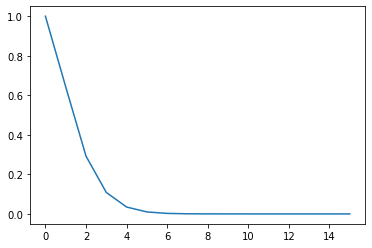

In [143]:
plt.plot(np.sqrt(displacement_norm**(x)/factorial(x)))

In [132]:
norms

array([1.00000000e+00, 4.13601729e-01, 8.90716114e-01, 9.75666767e-01,
       8.69915956e-01, 5.68440341e-01, 3.21583299e-01, 1.52609780e-01,
       6.69790542e-02, 2.68105448e-02, 1.03604700e-02, 3.79075070e-03,
       1.33140671e-03, 4.40502277e-04, 1.37672793e-04, 0.00000000e+00])

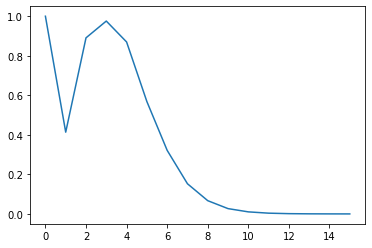

In [125]:
plt.plot(norms)

In [86]:
len(norms)

16

In [109]:
fct = factorial(2*x)

In [111]:
np.sqrt(norms**2*fct)**(1/(2*x))

/home/ocmob/miniconda3/envs/signatures_esig/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([1.        , 1.39162002, 1.69605701, 1.90926669, 2.08739196,
       2.19902817, 2.28851781, 2.3689018 , 2.45438686, 2.53833012,
       2.61209636, 2.67568019, 2.72965257, 2.77692534, 2.81921091,
       0.        ])

In [ ]:
norms*

In [ ]:
1.689103138831715 = gamma

In [62]:
np.sqrt(1.689103138831715*2)

1.8379897381822974

In [64]:
(1.8052332797666613*6)**(1/3)

2.2125590006613924

In [66]:
sig @ sig

15.605608292341367

In [69]:
psi(np.sqrt(sig @ sig))

6.974727565867958

In [67]:
normalize_sig(sig, 14) @ normalize_sig(sig, 14)

12.380862586180728

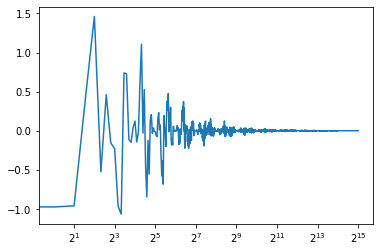

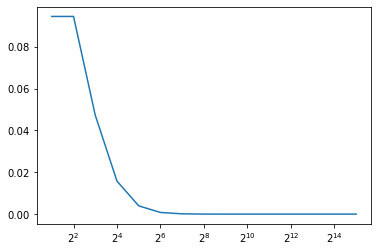

In [70]:
plt.figure()
plt.plot(sig)
plt.xscale('log', base = 2)

plt.figure()
plt.plot(xlog, y)
plt.xscale('log', base = 2)

In [112]:
get_lead_lag_proc_length(processes_ll[0, :, :].T)

9.923747973989505

Text(0, 0.5, 'Lag')

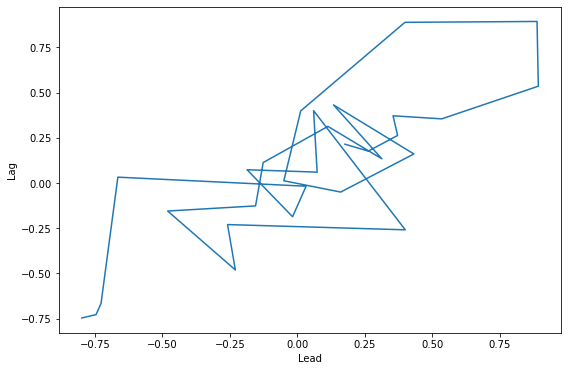

In [40]:
plt.figure(figsize=(9,6))
plt.plot(processes_ll[0, :, 0].reshape(30), processes_ll[0, :,1].reshape(30))
plt.xlabel('Lead')
plt.ylabel('Lag')